## Libraries

In [25]:
from google.colab import drive
import os
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import seaborn


## ESC-50

In [4]:
drive.mount('/content/drive')
audio_path = '/content/drive/My Drive/data/ESC-50-master/audio/'
audio_files = os.listdir(audio_path)
esc50_csv = pd.read_csv('/content/drive/My Drive/data/ESC-50-master/meta/esc50.csv')
esc50_csv.head()


Mounted at /content/drive


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
category_group = esc50_csv.groupby('category')['target'].first().sort_values()
for category, target in category_group.items():
    print(f"{target}: {category}")


0: dog
1: rooster
2: pig
3: cow
4: frog
5: cat
6: hen
7: insects
8: sheep
9: crow
10: rain
11: sea_waves
12: crackling_fire
13: crickets
14: chirping_birds
15: water_drops
16: wind
17: pouring_water
18: toilet_flush
19: thunderstorm
20: crying_baby
21: sneezing
22: clapping
23: breathing
24: coughing
25: footsteps
26: laughing
27: brushing_teeth
28: snoring
29: drinking_sipping
30: door_wood_knock
31: mouse_click
32: keyboard_typing
33: door_wood_creaks
34: can_opening
35: washing_machine
36: vacuum_cleaner
37: clock_alarm
38: clock_tick
39: glass_breaking
40: helicopter
41: chainsaw
42: siren
43: car_horn
44: engine
45: train
46: church_bells
47: airplane
48: fireworks
49: hand_saw


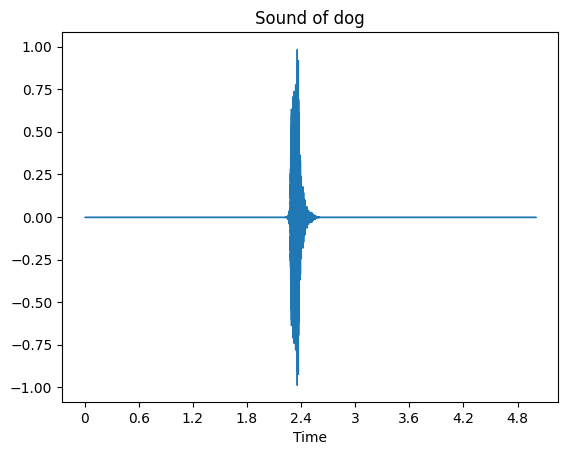

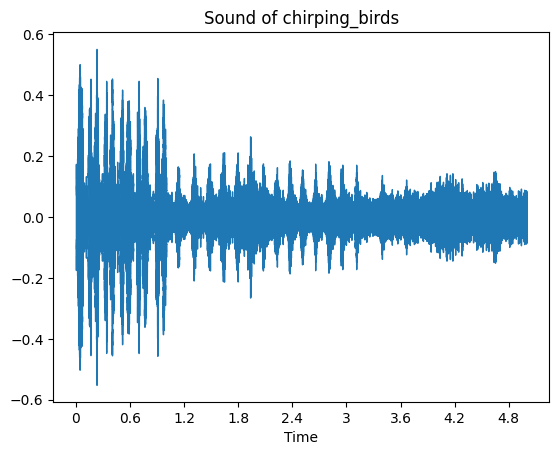

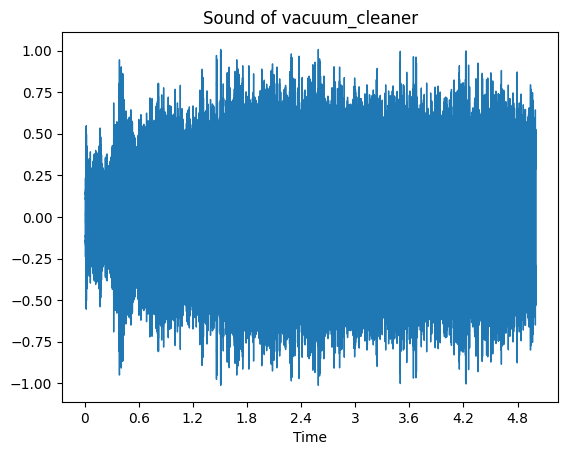

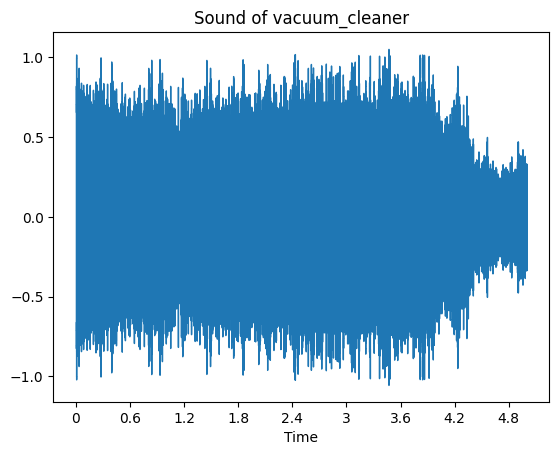

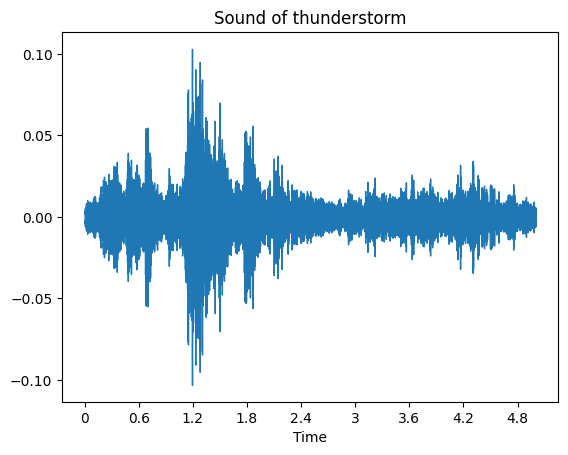

In [6]:
# Plot sound waves
for i in range(5):
    file_name = esc50_csv.loc[i, 'filename']
    file_path = os.path.join(audio_path, file_name)
    y, sr = librosa.load(file_path)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Sound of " + esc50_csv.loc[i, 'category'])
    plt.show()

## Example to visualize the Mel Spectrogram of the first file

In [7]:
# Load the first audio file with librosa
first_file = os.path.join(audio_path, audio_files[0])
y, sr = librosa.load(first_file)

# Play the first audio
ipd.Audio(first_file)

(128, 1025)


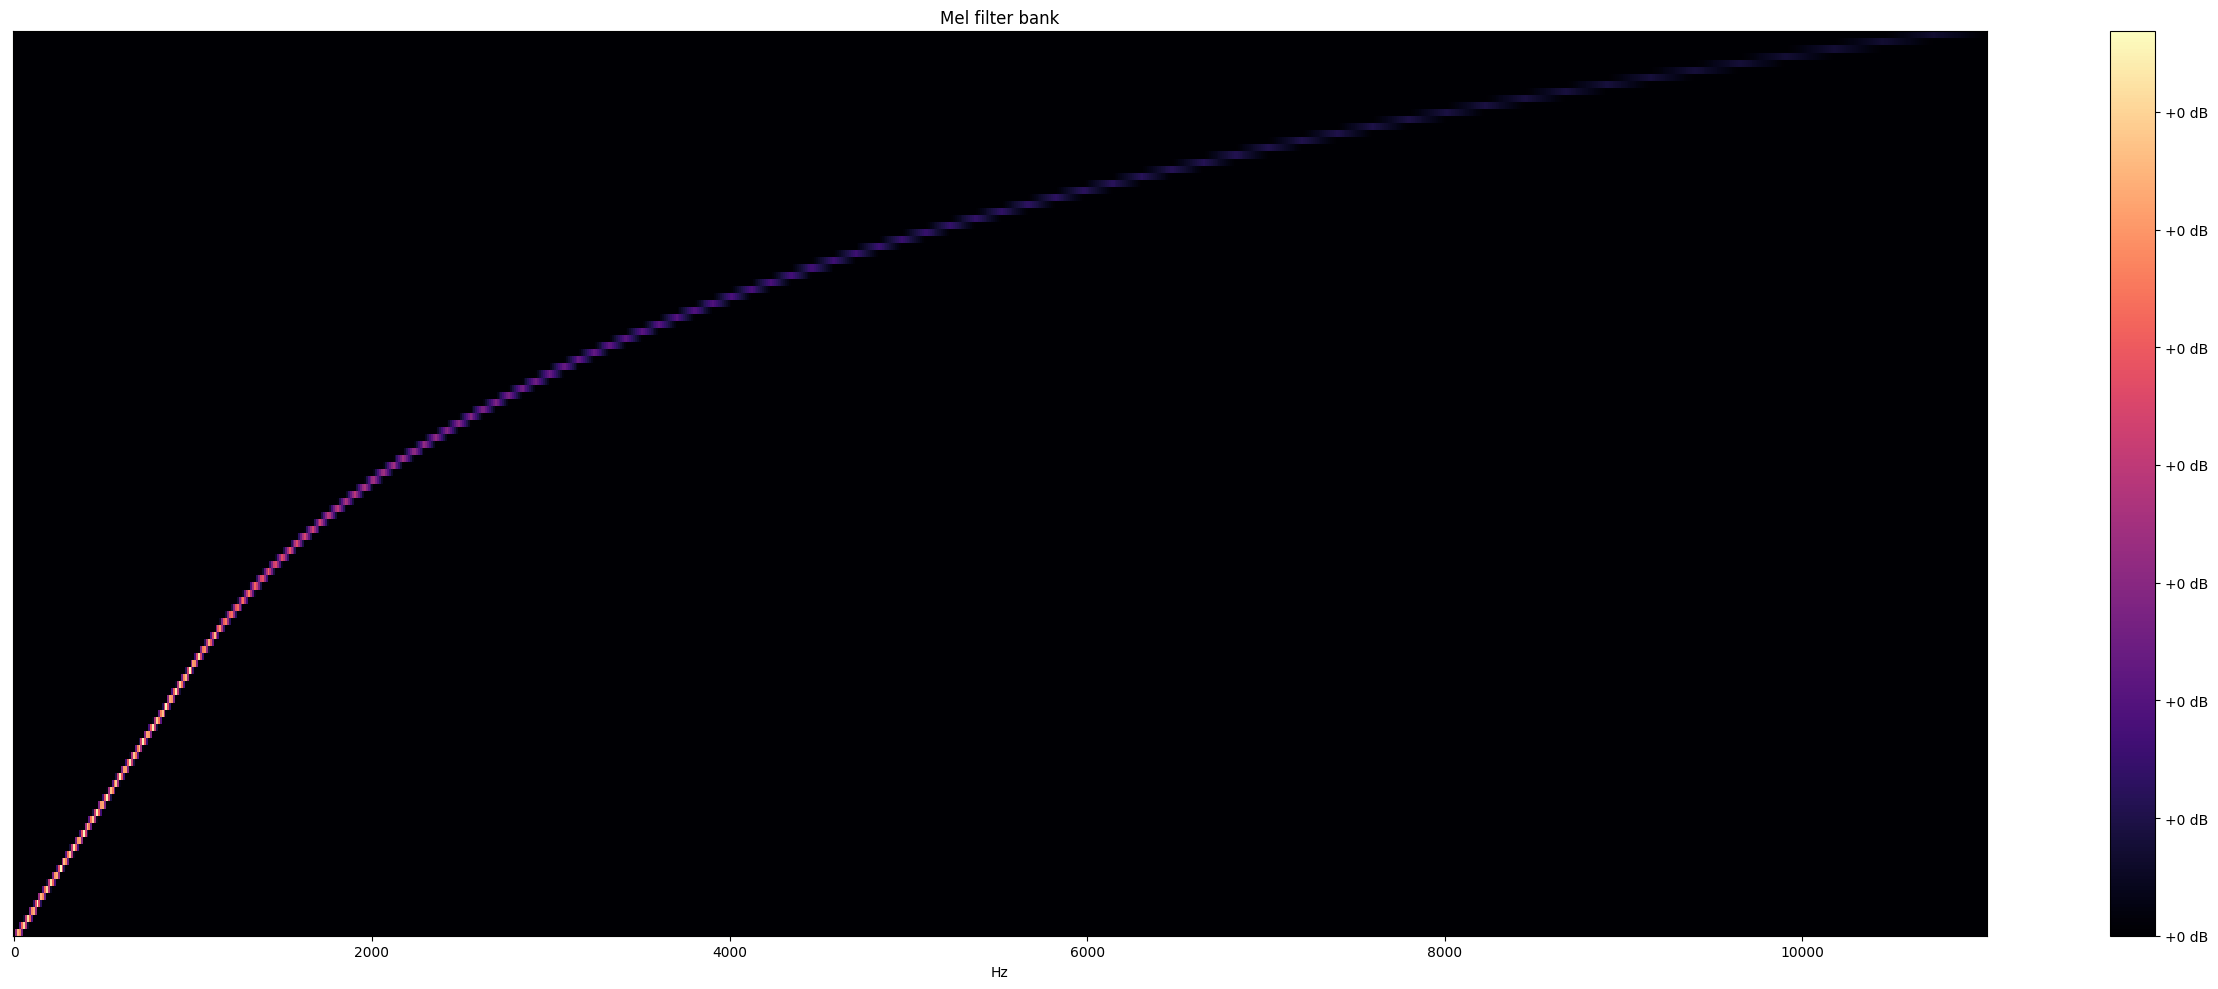

In [8]:
# Mel filter banks
filter_banks = librosa.filters.mel(sr=22050, n_fft=2048, n_mels=128)
print(filter_banks.shape)
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, x_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel filter bank')
plt.tight_layout()
plt.show()

(128, 216)


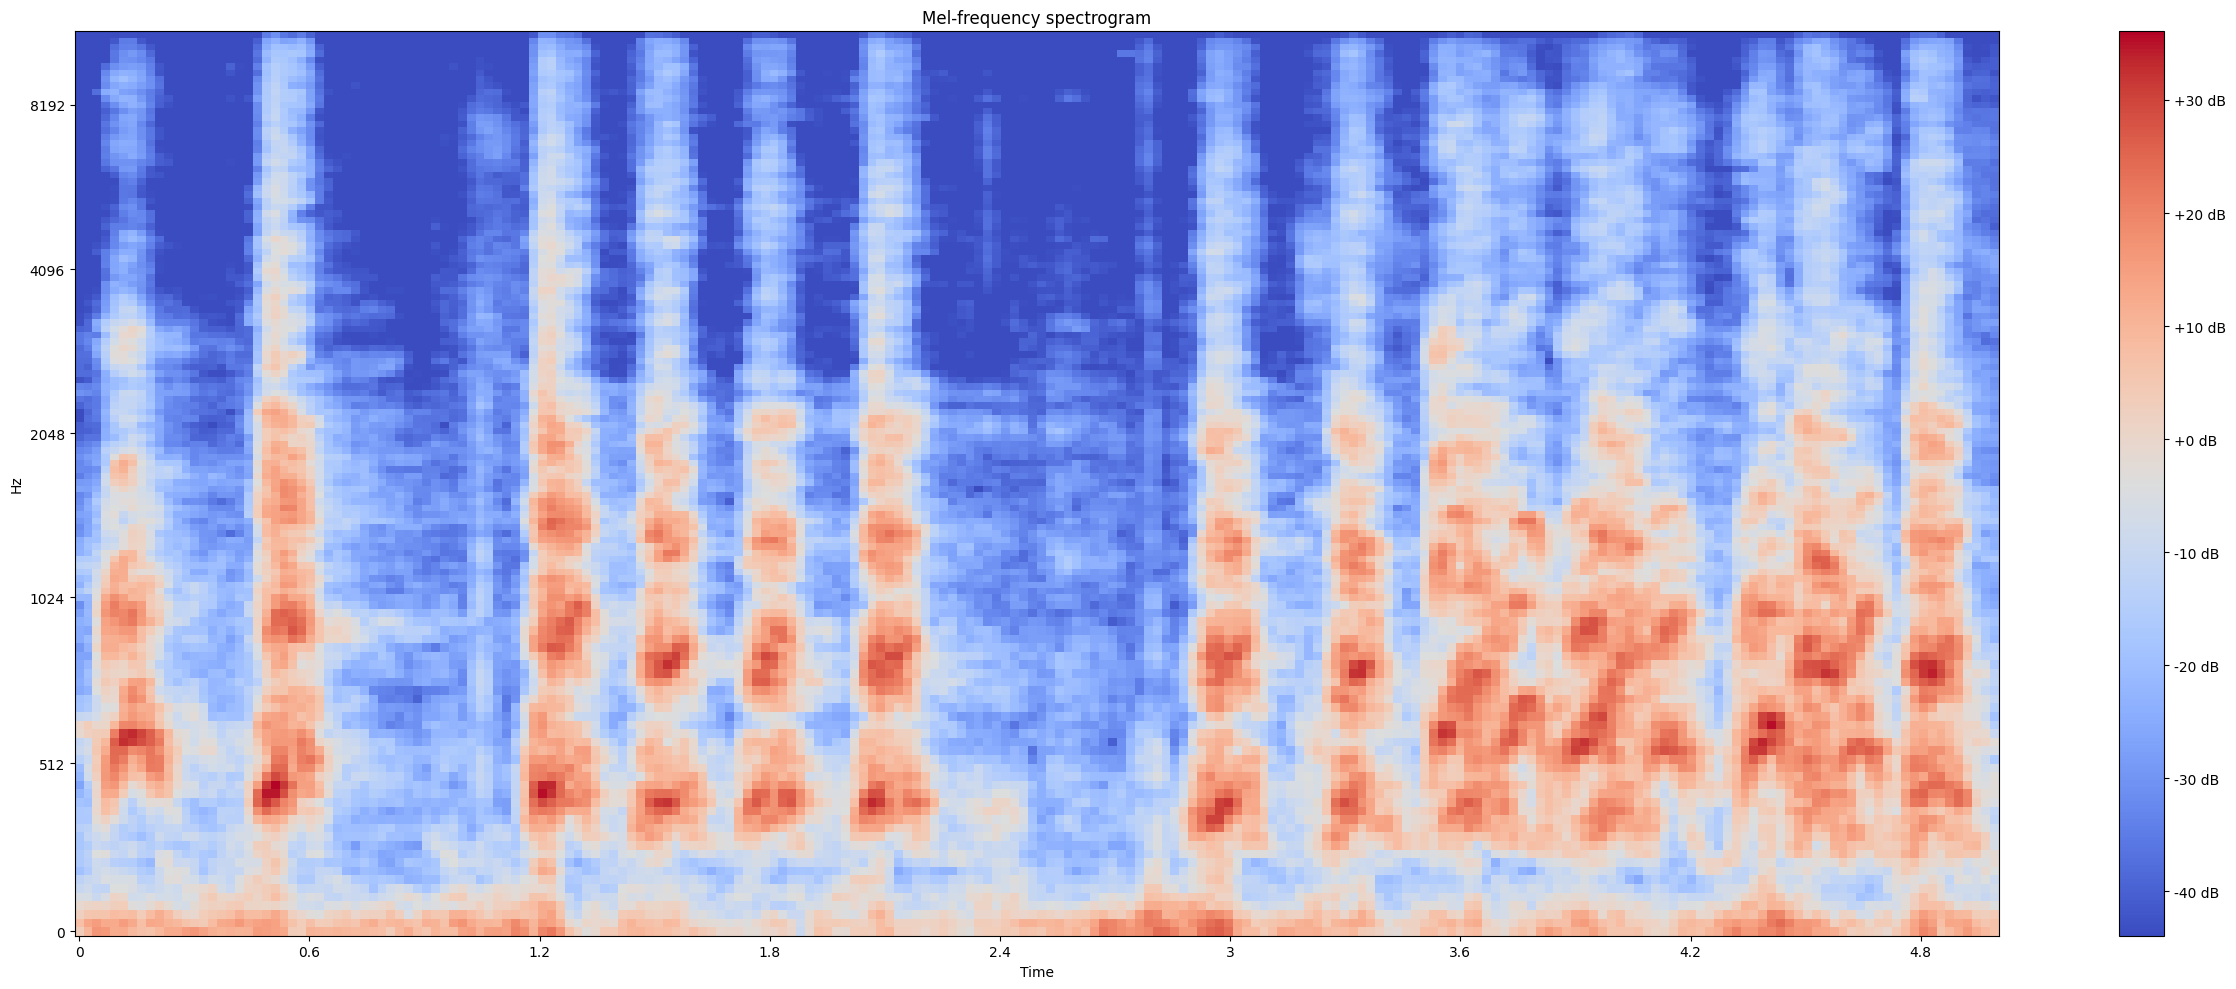

In [9]:
# Extracting Mel Spectrogram
melspectrogram_params = {
    'n_fft': 2048,
    'hop_length': 512,
    'n_mels': 128
}
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, **melspectrogram_params)
print(mel_spectrogram.shape)

# power_to_db
mel_spectrogram_pdb = librosa.power_to_db(mel_spectrogram)
plt.figure(figsize=(25, 10))
librosa.display.specshow(mel_spectrogram_pdb, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


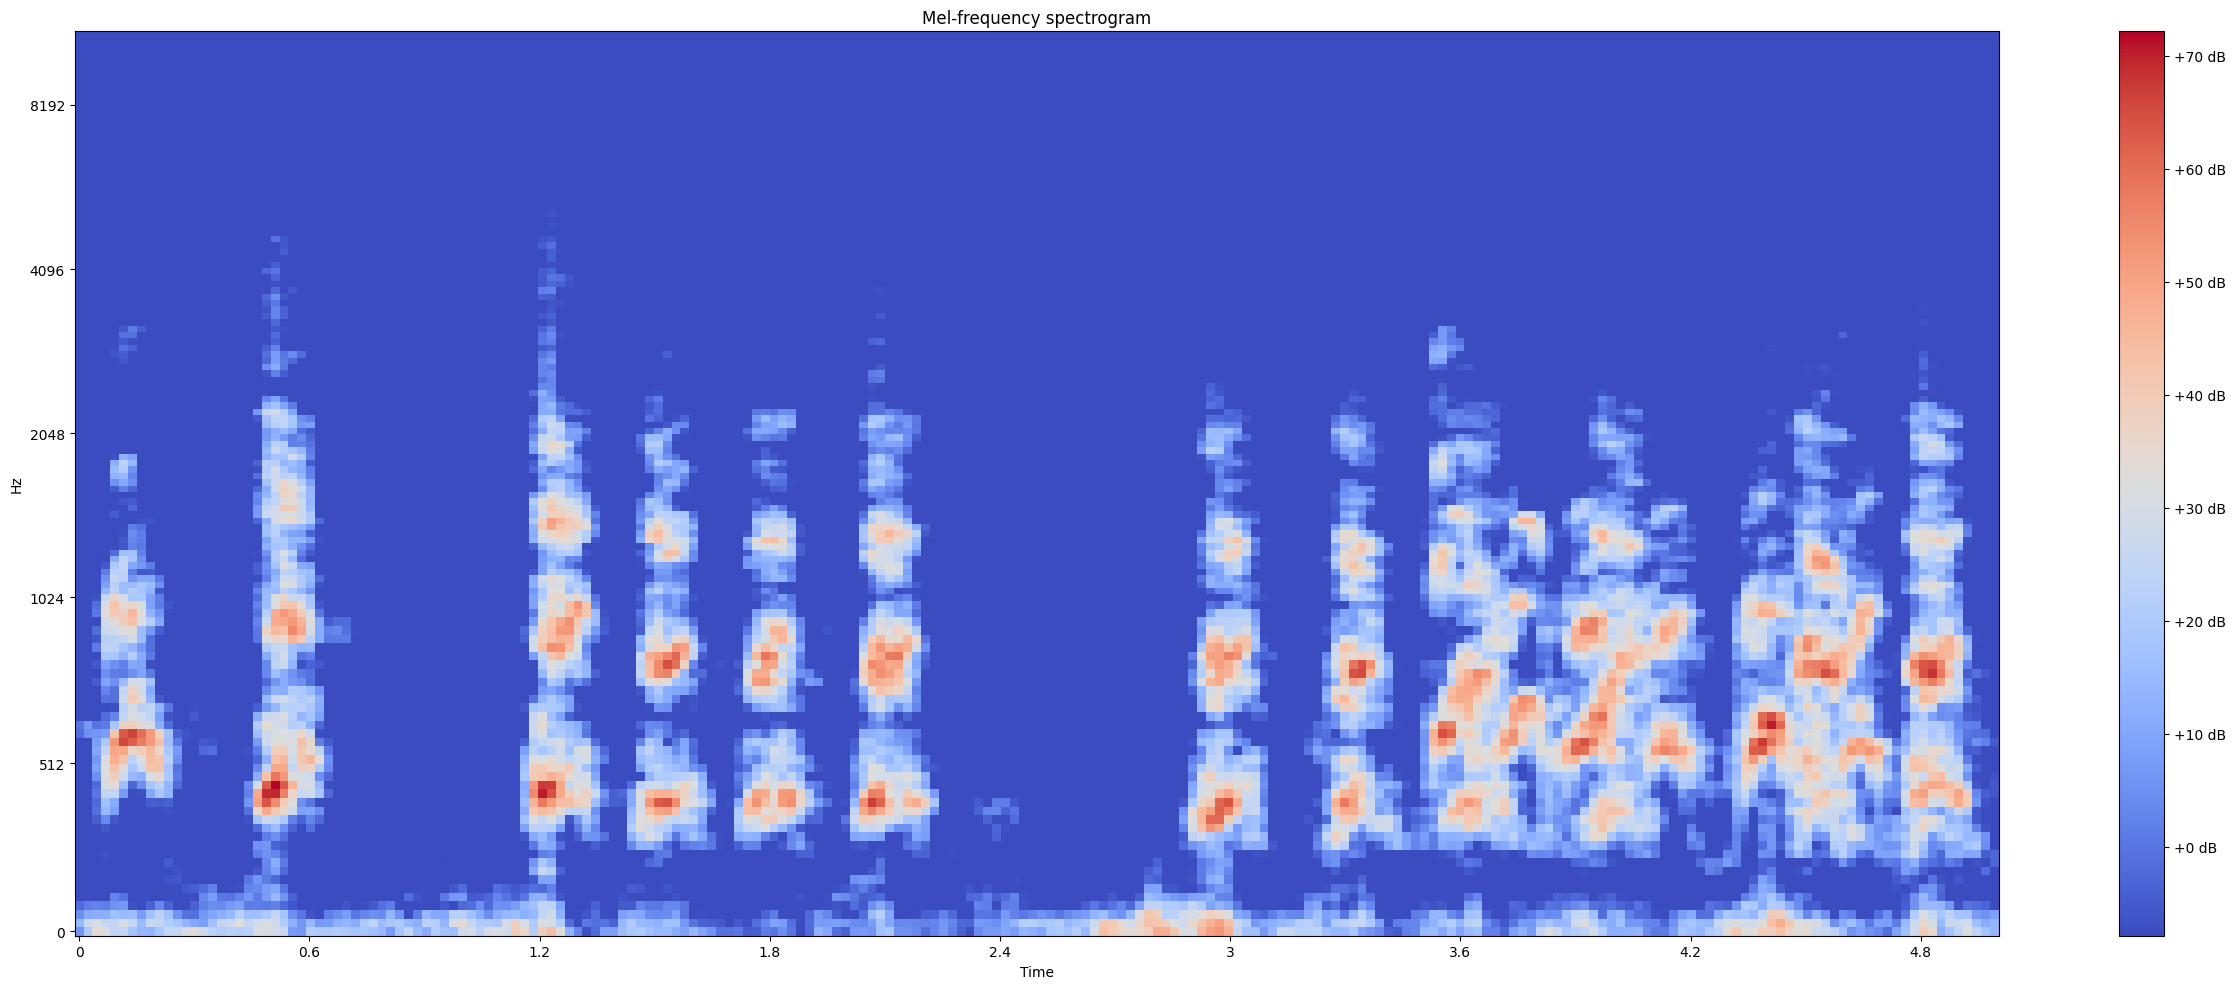

In [10]:
# amplitude_to_db
mel_spectrogram_adb = librosa.amplitude_to_db(mel_spectrogram)
plt.figure(figsize=(25, 10))
librosa.display.specshow(mel_spectrogram_adb, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

## Generate Mel Spectrogram images of our data

In [11]:
images_path = '/content/drive/My Drive/data/ESC-50-master/images/'
if not os.path.exists(images_path):
    os.makedirs(images_path)

In [ ]:
fig_size = (10,4)
def save_mel_spectrogram_image(file_path, image_name):

    # Load the audio file
    y, sr = librosa.load(file_path)
    # Extract Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, **melspectrogram_params)
    mel_spec_db = librosa.power_to_db(mel_spec)

    # Plot without axis
    plt.interactive(False)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    librosa.display.specshow(mel_spec_db)
    plt.tight_layout()
    # Save as image
    plt.savefig(os.path.join(images_path, f'{image_name}.png'))
    plt.close()


# Iterate through audio files and save Mel spectrograms
for file in audio_files:
    file_path = os.path.join(audio_path, file)
    file_name = os.path.splitext(file)[0]  # Remove file extension
    save_mel_spectrogram_image(file_path, file_name)



# Dataset

In [12]:
import pandas as pd
import os

# Dictionary to hold data for each fold
fold_data = {fold: [] for fold in range(1, 6)}

for index, row in esc50_csv.iterrows():
    image_name = row['filename'].replace('.wav', '.png')
    image_path = os.path.join(images_path, image_name)
    class_label = row['target']
    fold = row['fold']
    fold_data[fold].append((image_path, class_label))

print(fold_data[1][0])

('/content/drive/My Drive/data/ESC-50-master/images/1-100032-A-0.png', 0)


In [26]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MelSpectrogramDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        # Load image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if grayscale
        # Transform image
        if self.transform:
            image = self.transform(image)
        label = tensor(label, dtype=torch.long)
        return image, label

# Model

In [14]:

model = models.resnet18(pretrained=True)
# Replace the final layer to match the number of classes
num_classes = 50
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimize
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, dataloader, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in dataloader:
        x = x.to(device)
        y = y.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x)
        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)



def evaluate(model, dataloader, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in dataloader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
import time
num_epochs = 2
best_valid_loss = float('inf')

epoch_loss = 0
for big_epoch in range(num_epochs):
    big_epovh_loss = 0
    big_epoch_acc = 0
    for fold in range(1, 6):
        start_time = time.time()
        print(f"epoch {fold}")

        # Prepare training and validation data for the current fold
        train_folds = [f for f in range(1, 6) if f != fold]
        val_fold = fold

        train_data = [item for f in train_folds for item in fold_data[f]]
        val_data = fold_data[val_fold]

        train_dataset = MelSpectrogramDataset(train_data, transform=transform)
        val_dataset = MelSpectrogramDataset(val_data, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Train and evaluate the model for the current fold
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-model.pt')

        big_epovh_loss += train_loss
        big_epoch_acc += train_acc

        end_time = time.time()
        elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {big_epoch+1:02}-{fold} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

    big_epovh_loss /= 5
    big_epoch_acc /= 5
    print(f'Big Epoch: {big_epoch+1} | Big Epoch Loss: {big_epovh_loss:.3f} | Big Epoch Acc: {big_epoch_acc*100:.2f}%')


epoch 1
Epoch: 01-1 | Epoch Time: 13m 48s
Train Loss: 2.639 | Train Acc: 31.69%
Valid Loss: 2.667 | Valid Acc: 36.78%
epoch 2
Epoch: 01-2 | Epoch Time: 0m 27s
Train Loss: 1.375 | Train Acc: 58.81%
Valid Loss: 1.900 | Valid Acc: 48.56%
epoch 3
Epoch: 01-3 | Epoch Time: 0m 26s
Train Loss: 1.118 | Train Acc: 67.38%
Valid Loss: 1.082 | Valid Acc: 65.87%
epoch 4
Epoch: 01-4 | Epoch Time: 0m 29s
Train Loss: 0.815 | Train Acc: 74.50%
Valid Loss: 0.970 | Valid Acc: 70.43%
epoch 5
Epoch: 01-5 | Epoch Time: 0m 27s
Train Loss: 0.534 | Train Acc: 84.38%
Valid Loss: 0.482 | Valid Acc: 83.65%
Big Epoch: 1 | Big Epoch Loss: 1.296 | Big Epoch Acc: 63.35%
epoch 1
Epoch: 02-1 | Epoch Time: 0m 27s
Train Loss: 0.514 | Train Acc: 83.12%
Valid Loss: 0.681 | Valid Acc: 77.40%
epoch 2
Epoch: 02-2 | Epoch Time: 0m 27s
Train Loss: 0.454 | Train Acc: 86.94%
Valid Loss: 0.517 | Valid Acc: 83.41%
epoch 3
Epoch: 02-3 | Epoch Time: 0m 27s
Train Loss: 0.288 | Train Acc: 90.31%
Valid Loss: 0.364 | Valid Acc: 87.74%
ep

# Evaluating the model

In [18]:
import random
random_number = random.randint(1, 5)
print(random_number)

test_data = fold_data[random_number]
test_dataset = MelSpectrogramDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load('best-model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

2
Test Loss: 0.230 | Test Acc: 93.03%


In [19]:
def get_predictions(model, dataloader, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in dataloader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            y_prob = torch.nn.functional.softmax(y_pred, dim=1)

            labels.append(y)
            probs.append(y_prob)

    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs


labels, probs = get_predictions(model, test_loader, device)

pred_labels = torch.argmax(probs, 1)

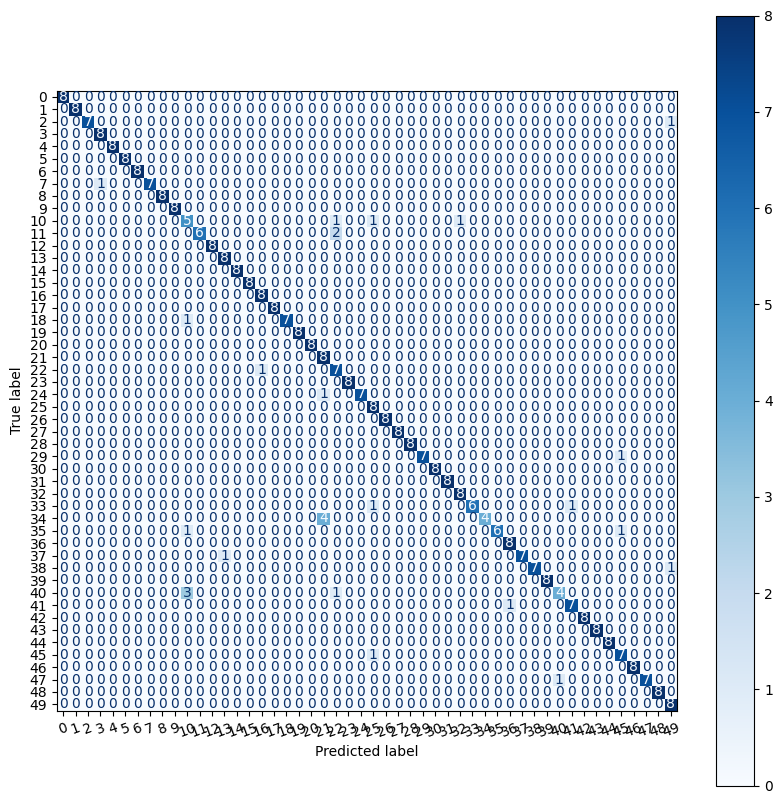

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

plot_confusion_matrix(labels.cpu(), pred_labels.cpu())